### BERT

In [ ]:
from transformers import BertTokenizer
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the dataset
data = pd.read_csv('../Data/labeled_reviews.csv')

# Adjust the labels (from -1, 0, 1 to 0, 1, 2)
data['sentiment'] = data['sentiment'].replace({-1: 0, 0: 1, 1: 2})

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# Tokenization function
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512)

# Apply tokenization and store tokenized results
train_data_enc = train_data['text'].apply(lambda x: tokenize_function(x))
test_data_enc = test_data['text'].apply(lambda x: tokenize_function(x))

# Convert tokenized results to columns
train_data['input_ids'] = train_data_enc.apply(lambda x: x['input_ids'])
train_data['attention_mask'] = train_data_enc.apply(lambda x: x['attention_mask'])
test_data['input_ids'] = test_data_enc.apply(lambda x: x['input_ids'])
test_data['attention_mask'] = test_data_enc.apply(lambda x: x['attention_mask'])

# Prepare dataset for PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# Convert train and test data into PyTorch Dataset format
train_dataset = SentimentDataset(
    input_ids=train_data['input_ids'].tolist(),
    attention_mask=train_data['attention_mask'].tolist(),
    labels=train_data['sentiment'].tolist()  
)
test_dataset = SentimentDataset(
    input_ids=test_data['input_ids'].tolist(),
    attention_mask=test_data['attention_mask'].tolist(),
    labels=test_data['sentiment'].tolist()  
)

# Custom collate function to handle dynamic padding
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Create DataLoader for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

# Define your BERT model for sequence classification
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training Loop
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_predictions = 0

    for batch in train_dataloader:
        # Move batch to GPU if available
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy
        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == batch_labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_predictions / len(train_data)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Nethma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train Loss: 0.5049
Train Accuracy: 0.8306
Epoch 2/3
Train Loss: 0.2942
Train Accuracy: 0.8882
Epoch 3/3
Train Loss: 0.1569
Train Accuracy: 0.9518


In [3]:
from sklearn.metrics import classification_report

# Set model to evaluation mode
model.eval()

true_labels = []
pred_labels = []

# No gradient calculations needed during evaluation
with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits

        # Get predictions
        preds = torch.argmax(logits, dim=-1)

        # Store results
        true_labels.extend(batch_labels.cpu().numpy())  # Convert tensors to numpy arrays
        pred_labels.extend(preds.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive'])
print(report)


              precision    recall  f1-score   support

    Negative       0.92      0.75      0.83        16
     Neutral       1.00      0.41      0.58        17
    Positive       0.93      1.00      0.97       180

    accuracy                           0.93       213
   macro avg       0.95      0.72      0.79       213
weighted avg       0.94      0.93      0.92       213



Compute class weights


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Nethma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train Loss: 0.9717, Train Accuracy: 0.7718
Test Loss: 0.7872, Test Accuracy: 0.8404

Epoch 2/3
Train Loss: 0.7173, Train Accuracy: 0.8553
Test Loss: 0.4967, Test Accuracy: 0.9343

Epoch 3/3
Train Loss: 0.4160, Train Accuracy: 0.9247
Test Loss: 0.3381, Test Accuracy: 0.9484


Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.75      0.75        12
     Neutral       0.75      0.75      0.75        16
    Positive       0.98      0.98      0.98       185

    accuracy                           0.95       213
   macro avg       0.83      0.83      0.83       213
weighted avg       0.95      0.95      0.95       213



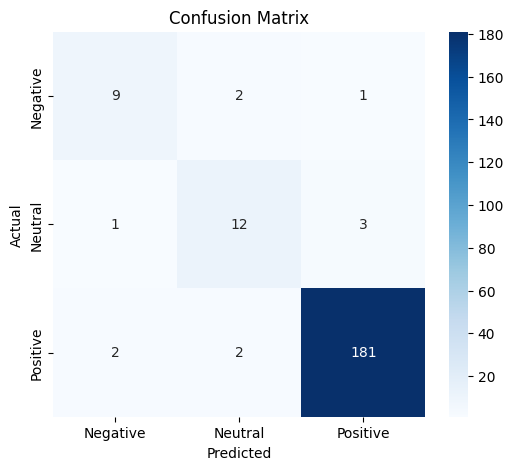

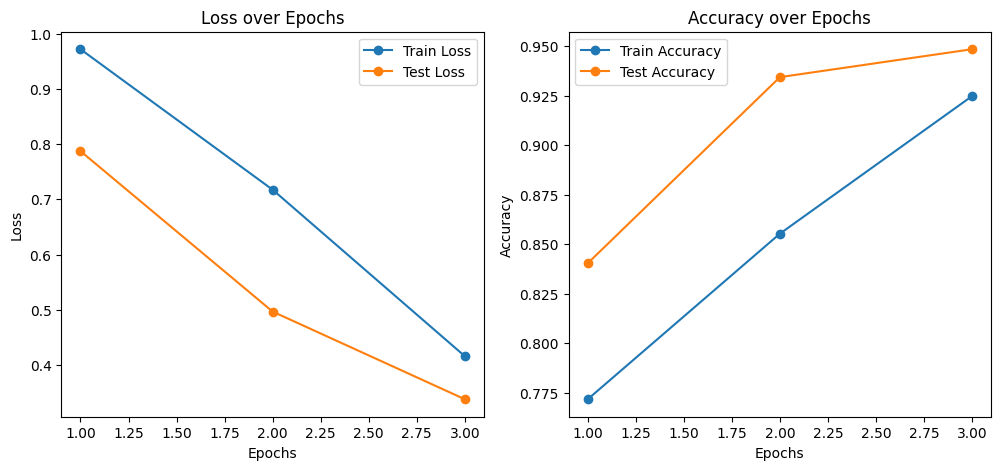

In [ ]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load dataset
data = pd.read_csv('../Data/labeled_reviews.csv')

# Adjust sentiment labels (-1 → 0, 0 → 1, 1 → 2)
data['sentiment'] = data['sentiment'].replace({-1: 0, 0: 1, 1: 2})

# Split data into training (80%) and testing (20%)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])

# Tokenization function
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

# Apply tokenization
train_data_enc = train_data['text'].apply(lambda x: tokenize_function(x))
test_data_enc = test_data['text'].apply(lambda x: tokenize_function(x))

# Convert tokenized results to columns
train_data['input_ids'] = train_data_enc.apply(lambda x: x['input_ids'].squeeze(0))
train_data['attention_mask'] = train_data_enc.apply(lambda x: x['attention_mask'].squeeze(0))
test_data['input_ids'] = test_data_enc.apply(lambda x: x['input_ids'].squeeze(0))
test_data['attention_mask'] = test_data_enc.apply(lambda x: x['attention_mask'].squeeze(0))

# PyTorch Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Convert to Dataset objects
train_dataset = SentimentDataset(
    input_ids=train_data['input_ids'].tolist(),
    attention_mask=train_data['attention_mask'].tolist(),
    labels=train_data['sentiment'].tolist()
)
test_dataset = SentimentDataset(
    input_ids=test_data['input_ids'].tolist(),
    attention_mask=test_data['attention_mask'].tolist(),
    labels=test_data['sentiment'].tolist()
)

# Custom collate function for dynamic padding
def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=0)
    attention_mask = torch.nn.utils.rnn.pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

# Load BERT model for classification
model = .from_pretrained('bert-base-uncased', num_labels=3)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# **Weighted Loss Function**
class_counts = train_data['sentiment'].value_counts().sort_index().values
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()  # Normalize
class_weights = class_weights.to(device)
loss_fn = CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training Variables
epochs = 3
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training Loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0

    for batch in train_dataloader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, batch_labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        correct_train_predictions += (preds == batch_labels).sum().item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / len(train_data)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation on test set
    model.eval()
    total_test_loss = 0
    correct_test_predictions = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            batch_input_ids = batch['input_ids'].to(device)
            batch_attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, batch_labels)
            total_test_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            correct_test_predictions += (preds == batch_labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_dataloader)
    test_accuracy = correct_test_predictions / len(test_data)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")

# **Classification Report & Confusion Matrix**
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Plot Training and Testing Metrics**
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


In [5]:
model.save_pretrained('../backend/bert_model')  # Save the model to a directory
tokenizer.save_pretrained('../backend/bert_model')  # Save the tokenizer

('../backend/bert_model\\tokenizer_config.json',
 '../backend/bert_model\\special_tokens_map.json',
 '../backend/bert_model\\vocab.txt',
 '../backend/bert_model\\added_tokens.json')